In [29]:
import numpy
from clustpy.deep import *
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import normalized_mutual_info_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.optimize import linear_sum_assignment

from embeddings_autoencoder import EmbeddingsAutoencoder
from gower_duped import gower_matrix as gower_matrix_duped

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome
0,12,10,1,0,0,0.139496,0,0,0,-0.695712,-0.569351,-0.411453,-0.251940,3
1,15,7,1,1,0,1.125461,1,1,0,-0.148192,-0.569351,2.984213,1.484611,0
2,17,4,2,2,0,-0.004031,1,0,0,-0.284101,-0.569351,2.894327,0.182198,0
3,12,4,1,2,0,0.037352,1,1,2,-0.229737,0.399020,-0.411453,-0.251940,3
4,41,1,1,1,0,-0.447419,1,0,2,-0.124893,-0.569351,-0.411453,-0.251940,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49727,33,9,1,2,0,-0.176460,0,0,0,2.791329,0.076230,-0.411453,-0.251940,3
49728,53,5,0,0,0,0.120447,0,0,0,0.768224,-0.246560,-0.411453,-0.251940,3
49729,54,5,1,1,0,1.429593,0,0,0,3.373797,0.721811,1.436189,1.050473,2
49730,39,1,1,1,0,-0.228024,0,0,1,0.970146,0.399020,-0.411453,-0.251940,3


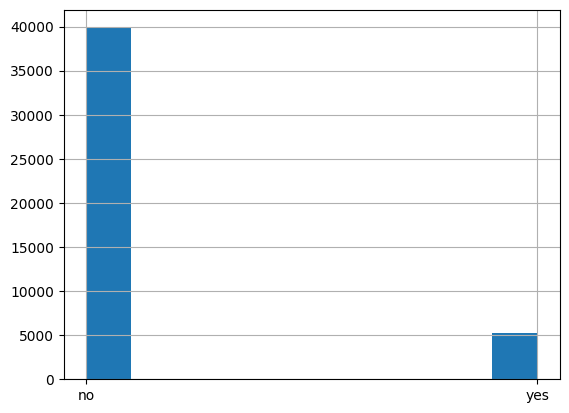

In [30]:
banking_df = pd.read_csv("datasets/banking_marketing.csv", sep=";")
banking_df.drop_duplicates(inplace=True)

banking_y = banking_df["y"]
banking_y.hist()
banking_y = LabelEncoder().fit_transform(banking_y)

banking_cat_cols = ["age", "job", "marital", "education", "default", "housing", "loan", "contact", "poutcome"]
banking_cont_cols = ["balance", "duration", "campaign", "pdays", "previous"]

banking_df.drop(columns=["y", "day", "month"], axis=1, inplace=True)
banking_df[banking_cat_cols] = banking_df[banking_cat_cols].apply(LabelEncoder().fit_transform)
banking_df[banking_cont_cols] = StandardScaler().fit_transform(banking_df[banking_cont_cols])
banking_df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.025724,7,-1.061993,9,1.136595,4,1,1,4,1,0.146804,-0.217195,-0.034304,39
1,0.828125,6,-1.007118,9,1.136595,2,4,0,4,1,-0.144847,-0.217195,-2.213335,39
2,-0.047221,4,0.245993,11,-0.419685,0,6,1,4,1,-0.144847,-0.217195,-0.034304,39
3,1.046961,4,0.426618,1,-1.197826,2,6,0,2,1,-0.144847,-0.217195,-0.034304,39
4,-0.776676,4,1.408464,9,1.136595,2,10,5,2,0,-0.144847,-0.217195,-0.034304,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,0.025724,4,0.243843,9,1.136595,0,10,1,4,0,-0.144847,-0.217195,-0.357123,39
48838,1.849362,0,1.247430,11,-0.419685,6,0,2,2,1,-0.144847,-0.217195,-0.034304,39
48839,-0.047221,4,1.754792,9,1.136595,2,10,0,4,1,-0.144847,-0.217195,0.772745,39
48840,0.390452,4,-1.001626,9,1.136595,0,1,3,1,1,0.586964,-0.217195,-0.034304,39


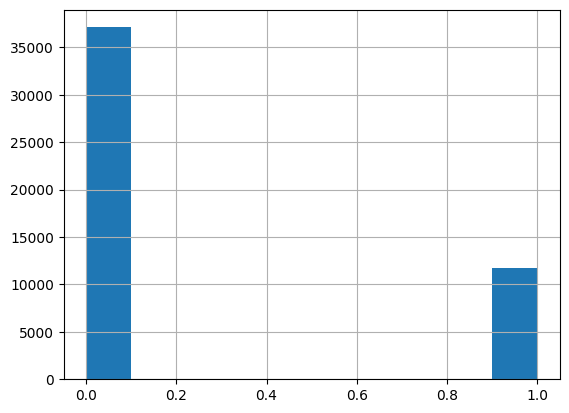

In [31]:
census_df = pd.read_csv("datasets/census_income.csv")
census_df.drop_duplicates(inplace=True)

census_df.loc[(census_df["class"] == " <=50K.") | (census_df["class"] == " <=50K"), "class"] = 0
census_df.loc[(census_df["class"] == " >50K.") | (census_df["class"] == " >50K"), "class"] = 1
census_df["class"].hist()
census_y = census_df["class"].to_numpy()

census_cat_cols = ["workclass", "education", "marital-status", "occupation", "relationship", "race", "sex", "native-country"]
census_cont_cols = ["age", "fnlwgt", "education-num", "capital-gain", "capital-loss", "hours-per-week"]

census_df.drop(columns="class", inplace=True)
census_df[census_cat_cols] = census_df[census_cat_cols].apply(LabelEncoder().fit_transform)
census_df[census_cont_cols] = StandardScaler().fit_transform(census_df[census_cont_cols])
census_df

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15
0,1,-0.056962,-0.961440,1,0,12,7,-0.295171,1,1,-0.302596,0,0,0.128682,-0.193125
1,0,2.296536,-0.073565,1,0,10,3,0.236217,1,1,0.704516,0,0,-0.816802,-0.086443
2,0,-0.592078,-0.861903,1,0,10,3,-0.220955,1,0,-0.504019,0,0,0.592504,-0.036150
3,1,-0.310572,-0.654865,1,0,12,7,0.446990,1,1,0.503093,1,0,-0.477855,-0.192553
4,1,-0.958122,0.158358,1,0,12,7,-0.158613,1,0,-0.504019,0,2,-0.358926,-0.193125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,1,-0.881193,1.046233,2,2,4,3,-0.295171,0,0,-0.504019,0,0,0.473575,-0.193125
686,0,-0.746780,-0.812134,1,0,1,7,-0.072523,0,1,-0.101174,1,0,0.116789,-0.118066
687,0,-0.528676,1.726075,2,2,5,2,-0.072523,0,1,-0.302596,1,0,0.116789,-0.192934
688,1,-1.148329,-0.920630,1,0,0,7,-0.654378,0,0,-0.504019,0,0,0.592504,-0.050247


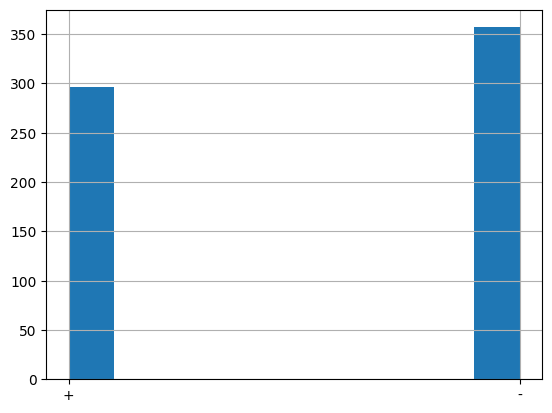

In [32]:
credit_df = pd.read_csv("datasets/credit_approval.csv")
credit_df.replace("?", pd.NA, inplace=True)
credit_df.dropna(inplace=True)
credit_df.drop_duplicates(inplace=True)

credit_y = credit_df["A16"]
credit_y.hist()
credit_y = LabelEncoder().fit_transform(credit_y)

credit_cat_cols = ["A1", "A4", "A5", "A6", "A7", "A9", "A10", "A12", "A13"]
credit_cont_cols = ["A2", "A3", "A8", "A11", "A14", "A15"]

credit_df.drop(columns="A16", inplace=True)
credit_df[credit_cat_cols] = credit_df[credit_cat_cols].apply(LabelEncoder().fit_transform)
credit_df[credit_cont_cols] = StandardScaler().fit_transform(credit_df[credit_cont_cols])
credit_df

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal
0,1.007386,1,3,0.675287,0.305908,1,0,0.480653,0,1.303159,0,-0.724064,0
1,1.432034,1,0,1.462483,0.784599,0,0,-1.140262,1,0.569611,1,2.487454,1
2,1.432034,1,0,-0.636705,0.269780,0,0,-0.329805,1,1.578239,1,1.416948,2
3,-1.752828,1,2,-0.111908,0.459450,0,1,1.908602,0,2.403480,0,-0.724064,1
4,-1.328180,0,1,-0.111908,0.043982,0,0,1.329704,0,0.477918,2,-0.724064,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,0.051927,0,0,-0.269347,1.209099,1,2,0.635026,0,-0.805791,3,NaN,3
916,0.901224,1,3,NaN,-0.543092,0,2,NaN,2,NaN,3,NaN,3
917,0.158089,1,0,-0.531745,0.215589,1,2,-1.449008,0,-0.805791,3,NaN,0
918,0.476575,1,0,NaN,1.678758,1,0,NaN,2,NaN,3,NaN,3


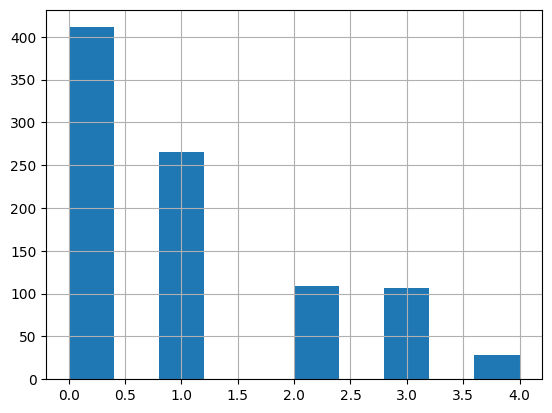

In [33]:
heart_df = pd.read_csv("datasets/heart_disease.csv")
heart_df.drop_duplicates(inplace=True)

heart_df["num"].hist()
heart_y = heart_df["num"].to_numpy()

heart_cat_cols = ["sex", "cp", "fbs", "restecg", "exang", "slope", "thal"]
heart_cont_cols = ["age", "trestbps", "chol", "thalch", "oldpeak", "ca"]

heart_df.drop(columns=["id", "dataset", "num"], inplace=True)
heart_df[heart_cat_cols] = heart_df[heart_cat_cols].apply(LabelEncoder().fit_transform)
heart_df[heart_cont_cols] = StandardScaler().fit_transform(heart_df[heart_cont_cols])
heart_df

In [34]:
class BankingDataset(Dataset):
    def __init__(self, df):
        self.cat = torch.tensor(df[banking_cat_cols].values, dtype=torch.float)
        self.cont = torch.tensor(df[banking_cont_cols].values, dtype=torch.float)
    def __getitem__(self, idx):
        return self.cat[idx], self.cont[idx]
    def __len__(self):
        return self.cat.shape[0]

banking_dataloader = DataLoader(BankingDataset(banking_df), batch_size=512, shuffle=True)

banking_emb_sizes = [(banking_df[col].nunique(), min(50, max(2, (banking_df[col].nunique()+1) // 2))) for col in banking_df[banking_cat_cols]]
banking_emb_sizes

[(77, 39), (12, 6), (3, 2), (4, 2), (2, 2), (2, 2), (2, 2), (3, 2), (4, 2)]

In [35]:
class CensusDataset(Dataset):
    def __init__(self, df):
        self.cat = torch.tensor(df[census_cat_cols].values, dtype=torch.float)
        self.cont = torch.tensor(df[census_cont_cols].values, dtype=torch.float)

    def __getitem__(self, idx):
        return self.cat[idx], self.cont[idx]

    def __len__(self):
        return self.cat.shape[0]


census_dataloader = DataLoader(CensusDataset(census_df), batch_size=512, shuffle=True)

census_emb_sizes = [(census_df[col].nunique(), min(50, max(2, (census_df[col].nunique() + 1) // 2))) for col in
                     census_df[census_cat_cols]]
census_emb_sizes

[(9, 5), (16, 8), (7, 4), (15, 8), (6, 3), (5, 3), (2, 2), (42, 21)]

In [36]:
class CreditDataset(Dataset):
    def __init__(self, df):
        self.cat = torch.tensor(df[credit_cat_cols].values, dtype=torch.float)
        self.cont = torch.tensor(df[credit_cont_cols].values, dtype=torch.float)

    def __getitem__(self, idx):
        return self.cat[idx], self.cont[idx]

    def __len__(self):
        return self.cat.shape[0]


credit_dataloader = DataLoader(CreditDataset(credit_df), batch_size=512, shuffle=True)

credit_emb_sizes = [(credit_df[col].nunique(), min(50, max(2, (credit_df[col].nunique() + 1) // 2))) for col in
                    credit_df[credit_cat_cols]]
credit_emb_sizes

[(2, 2), (3, 2), (3, 2), (14, 7), (9, 5), (2, 2), (2, 2), (2, 2), (3, 2)]

In [37]:
class HeartDataset(Dataset):
    def __init__(self, df):
        self.cat = torch.tensor(df[heart_cat_cols].values, dtype=torch.float)
        self.cont = torch.tensor(df[heart_cont_cols].values, dtype=torch.float)

    def __getitem__(self, idx):
        return self.cat[idx], self.cont[idx]

    def __len__(self):
        return self.cat.shape[0]


heart_dataloader = DataLoader(HeartDataset(heart_df), batch_size=512, shuffle=True)

heart_emb_sizes = [(heart_df[col].nunique(), min(50, max(2, (heart_df[col].nunique() + 1) // 2))) for col in
                    heart_df[heart_cat_cols]]
heart_emb_sizes

[(2, 2), (4, 2), (3, 2), (4, 2), (3, 2), (4, 2), (4, 2)]